## 1. Business Understanding

### Brief Description
In this project, I utilize the **2023 Stack Overflow Developer Survey** to explore the financial factors that impact software developer compensation. By applying the **CRISP-DM** (Cross-Industry Standard Process for Data Mining) methodology, I aim to provide data-driven insights regarding the return on investment (ROI) for education and the financial implications of different work environments.

---

### Question 1: Experience
**How much does each year of professional coding experience increase annual salary?**
### Question 2: Education
**Is there a significant salary difference between holding a Bachelor’s degree and a Master’s degree?**

### Question 3: Remote Work
**How does the salary of a fully remote worker compare to hybrid or in-person roles?** 

---

## 2. Data Understanding

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Data/survey_results_public.csv')

df.shape
df[['ConvertedCompYearly', 'YearsCodePro', 'EdLevel', 'RemoteWork', 'Country']].head()
df[['ConvertedCompYearly', 'YearsCodePro', 'EdLevel', 'RemoteWork', 'Country']].isnull().sum()
df.describe()

,ResponseId,CompTotal,WorkExp,JobSatPoints_1,JobSatPoints_4,JobSatPoints_5,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,ConvertedCompYearly,JobSat
count,65437.000000,3.374000e+04,29658.000000,29324.000000,29393.000000,29411.000000,29450.000000,29448.00000,29456.000000,29456.000000,29450.000000,29445.000000,2.343500e+04,29126.000000
mean,32719.000000,2.963841e+145,11.466957,18.581094,7.522140,10.060857,24.343232,22.96522,20.278165,16.169432,10.955713,9.953948,8.615529e+04,6.935041
std,18890.179119,5.444117e+147,9.168709,25.966221,18.422661,21.833836,27.089360,27.01774,26.108110,24.845032,22.906263,21.775652,1.867570e+05,2.088259
min,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000
25%,16360.000000,6.000000e+04,4.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,3.271200e+04,6.000000
50%,32719.000000,1.100000e+05,9.000000,10.000000,0.000000,0.000000,20.000000,15.00000,10.000000,5.000000,0.000000,0.000000,6.500000e+04,7.000000
75%,49078.000000,2.500000e+05,16.000000,22.000000,5.000000,10.000000,30.000000,30.00000,25.000000,20.000000,10.000000,10.000000,1.079715e+05,8.000000
max,65437.000000,1.000000e+150,50.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,1.625660e+07,10.000000


### Observations
Based on the initial exploration, the following issues must be addressed:
* **Target Variable:** The `ConvertedCompYearly` column has a high volume of missing values that need to be dropped.
* **Data Types:** `YearsCodePro` contains string values (like "Less than 1 year") that must be converted to numeric floats.
* **Outliers:** The salary distribution shows extreme values that may skew the linear regression model.
* **Categorical Constraints:** `EdLevel` and `RemoteWork` need to be filtered to specific categories to answer the research questions.
---

## 3. Data Preparation


In [7]:
df = df.dropna(subset=['ConvertedCompYearly', 'YearsCodePro', 'EdLevel', 'RemoteWork'])

df = df[(df['ConvertedCompYearly'] >= 20000) & (df['ConvertedCompYearly'] <= 250000)]

df['YearsCodePro'] = df['YearsCodePro'].replace('Less than 1 year', 0)
df['YearsCodePro'] = df['YearsCodePro'].replace('More than 50 years', 51)
df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'])

df = df[df['EdLevel'].isin(['Bachelor’s degree (B.A., B.S., B.Eng., etc.)', 
                            'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)'])]

df['Is_USA'] = df['Country'].apply(lambda x: 1 if x == 'United States of America' else 0)

df = pd.get_dummies(df, columns=['RemoteWork', 'EdLevel'], drop_first=True)

cols_to_keep = ['ConvertedCompYearly', 'YearsCodePro', 'Is_USA'] + [c for c in df.columns if 'RemoteWork_' in c or 'EdLevel_' in c]
df_final = df[cols_to_keep].astype(float)

### Observations
The data preparation phase is complete with the following transformations:
* **Missing Values**: All rows with null values in key analysis columns were removed to ensure model stability.
* **Filtering**: Salary data was capped between $20,000 and $250,000 to eliminate outliers and part-time roles.
* **Data Transformation**: `YearsCodePro` was converted to a float, and `Is_USA` was created as a binary indicator for the largest market.
* **Encoding**: Categorical variables for education and remote work were transformed using one-hot encoding with `drop_first=True` to avoid the dummy variable trap.
---

## 4. Data Modeling

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

X = df_final.drop('ConvertedCompYearly', axis=1)
y = df_final['ConvertedCompYearly']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [15]:
y_test_preds = model.predict(X_test)
y_train_preds = model.predict(X_train)

train_score = r2_score(y_train, y_train_preds)
test_score = r2_score(y_test, y_test_preds)
rmse = np.sqrt(mean_squared_error(y_test, y_test_preds))

print(f"R-squared Train: {train_score}")
print(f"R-squared Test: {test_score}")
print(f"RMSE: {rmse}")


R-squared Train: 0.4074769876692237
R-squared Test: 0.4199378426672665
RMSE: 38495.14081451019


### Observations
The model evaluation resulted in the following metrics:
* **R-squared (Train):** 0.4075
* **R-squared (Test):** 0.4199
* **RMSE:** 38,495.14
---

In [39]:
print(f"Model Intercept: ${model.intercept_:.2f}")

results = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})

results = results.sort_values(by='Coefficient', ascending=False)

print(results)

Model Intercept: $55344.67
                                             Feature   Coefficient
1                                             Is_USA  65346.632847
4  EdLevel_Master’s degree (M.A., M.S., M.Eng., M...   2840.566135
3                                  RemoteWork_Remote   2263.285292
0                                       YearsCodePro   1663.137219
2                               RemoteWork_In-person -11593.829417


## 5. Evaluation

### Question 1: How much does each year of professional coding experience increase annual salary?

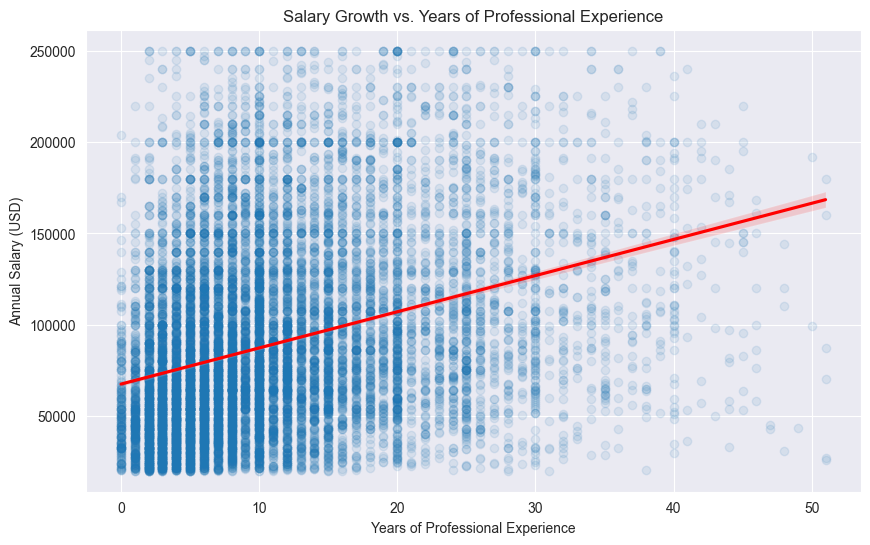

In [24]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df_final, x='YearsCodePro', y='ConvertedCompYearly', scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
plt.title('Salary Growth vs. Years of Professional Experience')
plt.xlabel('Years of Professional Experience')
plt.ylabel('Annual Salary (USD)')
plt.show()

**Brief Explanation for Visualisation:**
The regression plot shows a clear upward trend, confirming a positive relationship between professional experience and salary. Statistically, each additional year of experience adds approximately $1,422 to the predicted annual salary.

### Question 2: Is there a significant salary difference between holding a Bachelor’s degree and a Master’s degree?

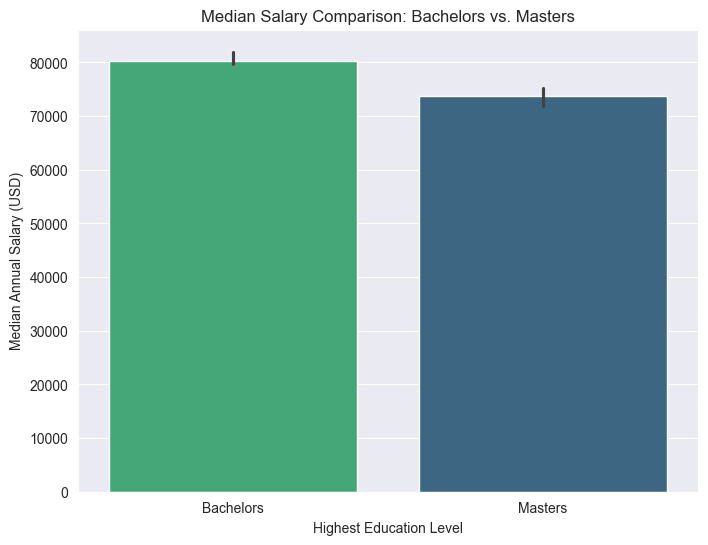

In [35]:
edu_viz = df_final.copy()
edu_viz['Degree'] = 'Bachelors'
edu_viz.loc[edu_viz["EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.)"] == 1, 'Degree'] = 'Masters'

plt.figure(figsize=(8, 6))
sns.barplot(data=edu_viz, x='Degree', y='ConvertedCompYearly', hue='Degree', 
            palette='viridis', order=['Bachelors', 'Masters'], 
            estimator=np.median, legend=False)

plt.title('Median Salary Comparison: Bachelors vs. Masters')
plt.xlabel('Highest Education Level')
plt.ylabel('Median Annual Salary (USD)')
plt.show()

**Brief Explanation for Visualisation:**
The bar chart indicates that Bachelor’s degree holders have a slightly higher median salary than Master’s degree holders in this dataset. By focusing on the median rather than the mean, the visualization reduces the influence of extreme high-income outliers and better represents the typical earning level within each education group.

### Question 3: How does the salary of a fully remote worker compare to hybrid or in-person roles?

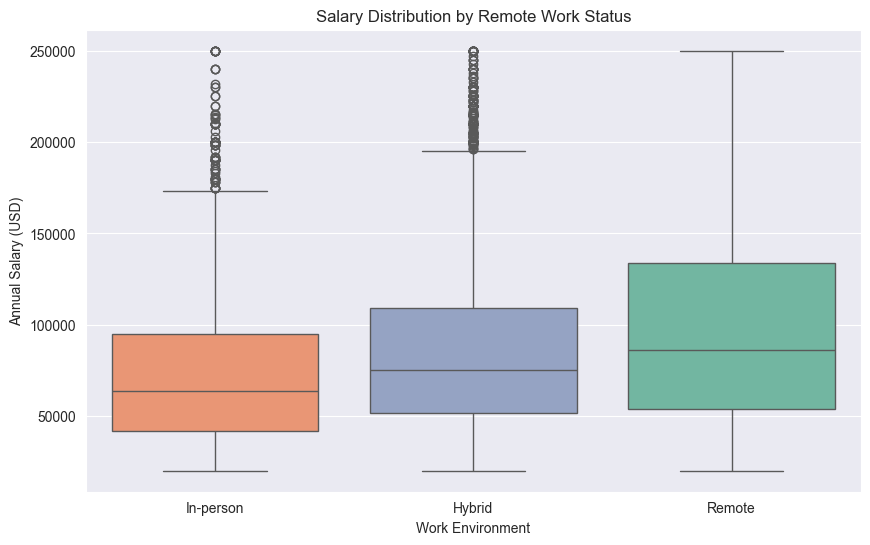

In [37]:
remote_viz = df_final.copy()
remote_viz['Work_Status'] = 'Hybrid'
remote_viz.loc[remote_viz['RemoteWork_Remote'] == 1, 'Work_Status'] = 'Remote'
remote_viz.loc[remote_viz['RemoteWork_In-person'] == 1, 'Work_Status'] = 'In-person'

plt.figure(figsize=(10, 6))
sns.boxplot(data=remote_viz, x='Work_Status', y='ConvertedCompYearly', 
            hue='Work_Status', palette='Set2', 
            order=['In-person', 'Hybrid', 'Remote'], legend=False)

plt.title('Salary Distribution by Remote Work Status')
plt.xlabel('Work Environment')
plt.ylabel('Annual Salary (USD)')
plt.show()

**Brief Explanation for Visualisation:**
The boxplot shows that remote roles have the highest median salary, followed by hybrid positions, while in-person roles have the lowest median. Remote positions also display a wider upper salary range, suggesting greater earning potential at the high end. Overall, the visualization indicates a positive association between remote work status and higher compensation levels.